In [1]:
import cv2
import numpy as np
import pandas as pd
from skimage.util import random_noise
from tqdm import tqdm
import os
from google.colab.patches import cv2_imshow

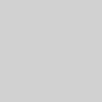

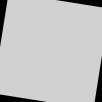

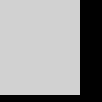

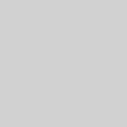

In [2]:
# преобразования положения
def rotation(img, angle = 45):
    angle = int(np.random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h), borderValue = (1, 1, 1))
    return img

def translation(img, shift = 500):
    w_shift = int(np.random.uniform(-shift, shift))
    h_shift = int(np.random.uniform(-shift, shift))
    h, w = img.shape[:2]
    M = np.array([[1, 0, w_shift], [0, 1, h_shift]], dtype=np.float32)
    img = cv2.warpAffine(img, M, (w, h), borderValue = (1, 1, 1))
    return img

def resize(img, scale = 1):
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    dim = (width, height)
    
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return img

example = np.full((102, 102, 3), 209, np.uint8)
cv2_imshow(example)
example = np.full((102, 102, 3), 209, np.uint8)
cv2_imshow(rotation(example))
example = np.full((102, 102, 3), 209, np.uint8)
cv2_imshow(translation(example, 50))
example = np.full((102, 102, 3), 209, np.uint8)
cv2_imshow(resize(example, 1.25))


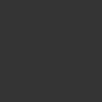

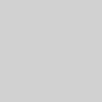

In [3]:
# преобразование изображения
def channel_shift(img, value = 60):
    value = int(np.random.uniform(-value, value))
    img = img + value
    img[:, :, :][img[:, :, :] > 255]  = 255
    img[:, :, :][img[:, :, :] < 0]  = 0
    img = img.astype(np.uint8)
    return img

def blur(img, shape = 10):
    k = np.random.randint(1, shape)
    return cv2.blur(img, (k, k))

example = np.full((102, 102, 3), 209, np.uint8)
cv2_imshow(channel_shift(example, 100))
example = np.full((102, 102, 3), 209, np.uint8)
cv2_imshow(blur(example))

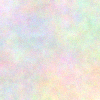

In [4]:
# эффект бумаги
def blank_paper(width=1024, height=1024, background=209):
    img = np.full((height, width, 3), background, np.uint8)
    return img

def add_noise(img, sigma=5):
    width, height, ch = img.shape
    img = img + noise(width, height, sigma=sigma)
    return img.clip(0, 255)

def noise(width, height, ratio=1, sigma=5):
    mean = 0
    h = int(height / ratio)
    w = int(width / ratio)
    result = np.random.normal(mean, sigma, (w, h, 3))
    if ratio > 1:
        result = cv2.resize(result, dsize=(width, height), interpolation=cv2.INTER_LINEAR)
    return result.reshape((width, height, 3))

def texture(image, sigma=5, turbulence=2):
    result = image.astype(float)
    cols, rows, ch = image.shape
    ratio = cols
    while not ratio == 1:
        result += noise(cols, rows, ratio, sigma=sigma)
        ratio = (ratio // turbulence) or 1
    cut = np.clip(result, 0, 255)
    return cut.astype(np.uint8)

def get_paper(width=1024, height=1024, colour = 230):
    return add_noise(texture(blank_paper(width, height, colour)))

cv2_imshow(get_paper(100, 100))

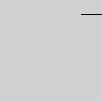

In [6]:
# дефект печати
def print_defect(img):
    shifted_rows = np.random.binomial(1, 0.01, img.shape[0])
    for i in range(img.shape[0]):
        if shifted_rows[i] == 1:
            shift = np.random.randint(-25, 25)
            new_row = np.zeros_like(img[i])
            if shift > 0:
                new_row[shift:] = img[i][:-shift]
            elif shift < 0:
                new_row[:shift] = img[i][-shift:]
            else:
                new_row = img[i]
            img[i] = new_row
    return img

example = np.full((102, 102, 3), 209, np.uint8)
cv2_imshow(print_defect(example))

In [5]:
def put_image_on_paper(img, bg):
    mask = np.zeros_like(img)
    mask[:, :, 0] = mask[:, :, 1] = mask[:, :, 2] = (img[:, :, 0] == 255) * (img[:, :, 1] == 255) * (img[:, :, 2] == 255)
    mask = mask.astype(bool)
    return bg[:img.shape[0], :img.shape[1]] * mask + img * ~mask

def put_image_on_background(img, bg):
    mask = np.zeros_like(img)
    mask[:, :, 0] = mask[:, :, 1] = mask[:, :, 2] = (img[:, :, 0] == 1) * (img[:, :, 1] == 1) * (img[:, :, 2] == 1)
    mask = mask.astype(bool)
    return bg * mask + img * ~mask

In [79]:
def make_augmentations(img):
    bg = cv2.imread('backgrounds/background_' + str(np.random.randint(2, 5)) + '.jpg')
    new_img = resize(img, np.random.randint(30, 65) / 100)
    new_img = print_defect(put_image_on_paper(new_img, paper))
    trick = np.ones_like(bg)
    trick[500:500 + new_img.shape[0], 500:500 + new_img.shape[1]] = new_img
    new_img = translation(rotation(trick))
    return blur(put_image_on_background(new_img, bg))

In [80]:
paper = get_paper(4096, 4096)

In [81]:
for file in tqdm(os.listdir('images/')):
    img = cv2.imread('images/' + file)
    for i in range(10):
        cv2.imwrite('/content/result/' + file[:-4]+ '_' + str(i) + '.png', make_augmentations(img))

100%|██████████| 10/10 [02:29<00:00, 14.91s/it]


In [78]:
!rm -rf result
!mkdir result